<a href="https://colab.research.google.com/github/Bellladraf6/machine-learning-labs/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Импорт необходимых библиотек

In [1]:
import os
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import tensorflow as tf


In [2]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(224, 224))

# Use MobileNetV2 instead of InceptionV3
img_height, img_width = 224, 224
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                      include_top=False, weights='imagenet')
pre_trained_model.trainable = False

last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

--2024-05-26 15:48:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 142.250.97.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   184MB/s    in 0.4s    

2024-05-26 15:48:10 (184 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step


In [4]:
# Training the model
history_mobilenet = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_steps=50,
                              verbose=2)

Epoch 1/10
100/100 - 289s - loss: 0.4315 - accuracy: 0.9185 - val_loss: 0.1637 - val_accuracy: 0.9730 - 289s/epoch - 3s/step
Epoch 2/10
100/100 - 271s - loss: 0.3744 - accuracy: 0.9350 - val_loss: 0.1084 - val_accuracy: 0.9780 - 271s/epoch - 3s/step
Epoch 3/10
100/100 - 258s - loss: 0.3017 - accuracy: 0.9360 - val_loss: 0.1126 - val_accuracy: 0.9770 - 258s/epoch - 3s/step
Epoch 4/10
100/100 - 301s - loss: 0.1703 - accuracy: 0.9565 - val_loss: 0.1188 - val_accuracy: 0.9760 - 301s/epoch - 3s/step
Epoch 5/10
100/100 - 248s - loss: 0.1917 - accuracy: 0.9620 - val_loss: 0.1022 - val_accuracy: 0.9760 - 248s/epoch - 2s/step
Epoch 6/10
100/100 - 290s - loss: 0.1626 - accuracy: 0.9605 - val_loss: 0.1814 - val_accuracy: 0.9690 - 290s/epoch - 3s/step
Epoch 7/10
100/100 - 256s - loss: 0.1290 - accuracy: 0.9650 - val_loss: 0.0883 - val_accuracy: 0.9830 - 256s/epoch - 3s/step
Epoch 8/10
100/100 - 250s - loss: 0.1769 - accuracy: 0.9590 - val_loss: 0.1499 - val_accuracy: 0.9710 - 250s/epoch - 2s/step


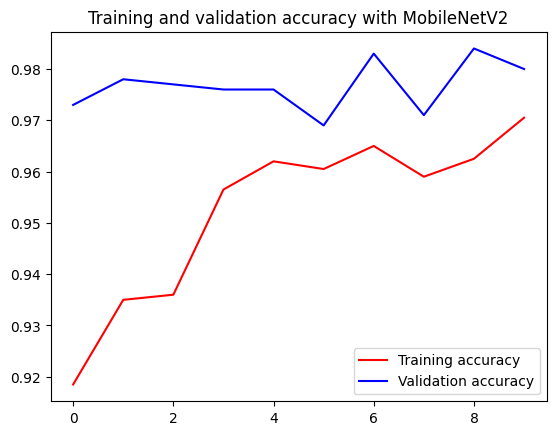

<Figure size 640x480 with 0 Axes>

In [5]:
# Plotting results
import matplotlib.pyplot as plt
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy with MobileNetV2')
plt.legend(loc=0)
plt.figure()
plt.show()